In [ ]:
#!pip install numpy pandas scikit-learn matplotlib seaborn

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [11]:
# Cargar el dataset
df = pd.read_csv('dataset_transporte.csv')

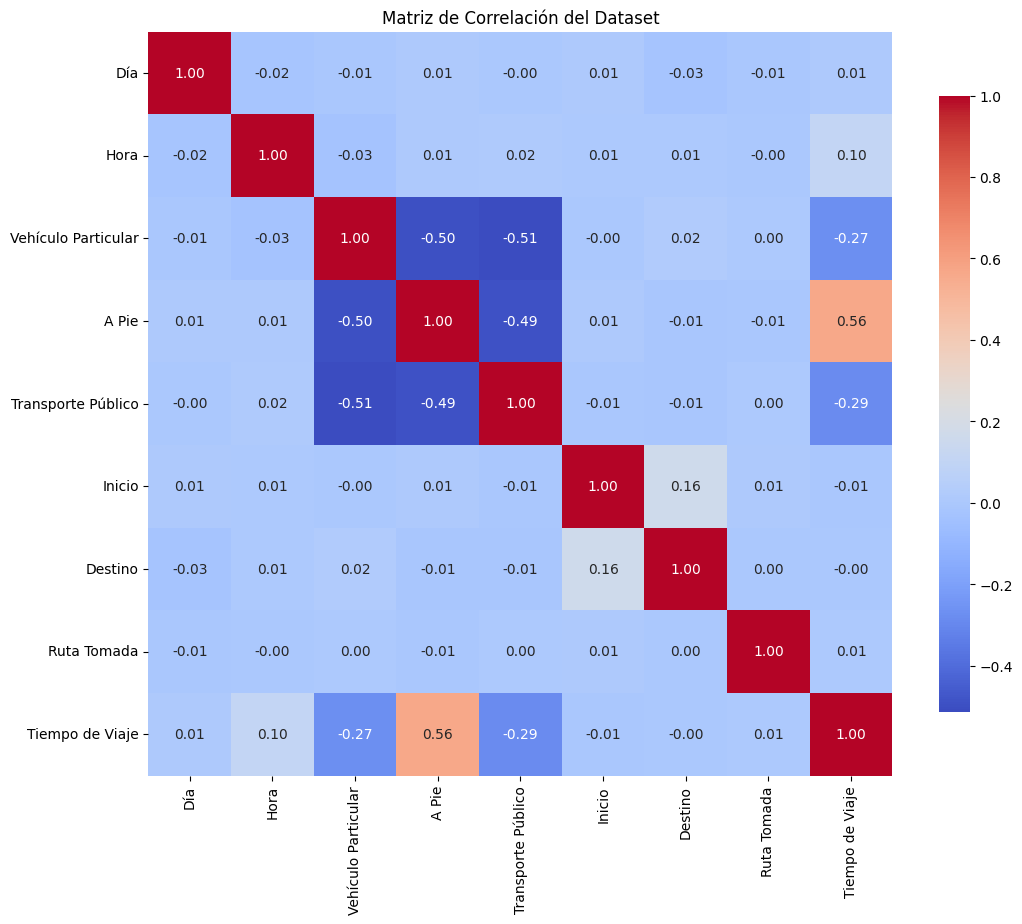

In [12]:
# Copiar el dataset para realizar la codificación
df_encoded = df.copy()

# Codificar las columnas categóricas en numéricas
label_encoders = {}
for column in df_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_encoded[column] = le.fit_transform(df_encoded[column])
    label_encoders[column] = le

# Calcular la matriz de correlación del dataset codificado
correlation_matrix_encoded = df_encoded.corr()

# Configurar el tamaño del gráfico
plt.figure(figsize=(12, 10))

# Crear el mapa de calor de la matriz de correlación
sns.heatmap(correlation_matrix_encoded, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})

# Configurar el título y mostrar el gráfico
plt.title("Matriz de Correlación del Dataset")
plt.show()

In [13]:
# Preprocesamiento de datos
label_encoders = {}
for column in ['Día', 'Inicio', 'Destino', 'Ruta Tomada']:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Crear una columna de clasificación para tiempo "Rápido" o "Lento"
umbral_tiempo = 35  # Umbral en minutos para clasificar el tiempo de viaje
df['Tiempo Clasificado'] = df['Tiempo de Viaje'].apply(lambda x: 1 if x < umbral_tiempo else 0)

# Separar características y etiquetas
X = df[['Día', 'Hora', 'Vehículo Particular', 'A Pie', 'Transporte Público', 'Inicio', 'Destino']]
y_ruta = df['Ruta Tomada']          # Etiqueta para predicción de la ruta
y_tiempo = df['Tiempo de Viaje']     # Etiqueta para predicción del tiempo de viaje
y_clasificacion = df['Tiempo Clasificado']  # Etiqueta binaria para rápido o lento

# Convertir variables categóricas a numéricas
X.loc[:, 'Vehículo Particular'] = X['Vehículo Particular'].apply(lambda x: 1 if x == 'Sí' else 0)
X.loc[:, 'A Pie'] = X['A Pie'].apply(lambda x: 1 if x == 'Sí' else 0)
X.loc[:, 'Transporte Público'] = X['Transporte Público'].apply(lambda x: 1 if x == 'Sí' else 0)

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_ruta_train, y_ruta_test, y_tiempo_train, y_tiempo_test, y_clasificacion_train, y_clasificacion_test = train_test_split(
    X, y_ruta, y_tiempo, y_clasificacion, test_size=0.2, random_state=42)

# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entrenar el modelo de regresión lineal para predecir el tiempo de viaje
linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled, y_tiempo_train)

# Entrenar el perceptrón para clasificar el tiempo como "Rápido" o "Lento"
perceptron_classifier = MLPClassifier(hidden_layer_sizes=(10,), max_iter=500, random_state=42)
perceptron_classifier.fit(X_train_scaled, y_clasificacion_train)

# Entrenar el modelo de clasificación para predecir la ruta
ruta_classifier = MLPClassifier(hidden_layer_sizes=(10,), max_iter=500, random_state=42)
ruta_classifier.fit(X_train_scaled, y_ruta_train)

# Función de predicción usando regresión lineal para el tiempo de viaje
def predecir_regresion_lineal(dia, hora, vehiculo_particular, a_pie, transporte_publico, inicio, destino):
    # Codificar las entradas
    dia_encoded = label_encoders['Día'].transform([dia])[0]
    inicio_encoded = label_encoders['Inicio'].transform([inicio])[0]
    destino_encoded = label_encoders['Destino'].transform([destino])[0]
    
    # Crear el array de entrada
    entrada = np.array([[dia_encoded, hora, vehiculo_particular, a_pie, transporte_publico, inicio_encoded, destino_encoded]])
    entrada_scaled = scaler.transform(entrada)
    
    # Predecir el tiempo de viaje
    tiempo_predicho = linear_reg.predict(entrada_scaled)[0]
    
    # Predecir la ruta
    ruta_predicha = ruta_classifier.predict(entrada_scaled)[0]
    ruta = label_encoders['Ruta Tomada'].inverse_transform([ruta_predicha])[0]
    
    return ruta, tiempo_predicho

# Función de clasificación rápida o lenta usando el perceptrón
def clasificar_tiempo_rapido_lento(dia, hora, vehiculo_particular, a_pie, transporte_publico, inicio, destino):
    # Codificar las entradas
    dia_encoded = label_encoders['Día'].transform([dia])[0]
    inicio_encoded = label_encoders['Inicio'].transform([inicio])[0]
    destino_encoded = label_encoders['Destino'].transform([destino])[0]
    
    # Crear el array de entrada
    entrada = np.array([[dia_encoded, hora, vehiculo_particular, a_pie, transporte_publico, inicio_encoded, destino_encoded]])
    entrada_scaled = scaler.transform(entrada)
    
    # Predecir la clasificación de tiempo rápido o lento
    clasificacion = perceptron_classifier.predict(entrada_scaled)[0]
    return "Rápido" if clasificacion == 1 else "Lento"

C:\Users\zarpi\AppData\Local\Temp\ipykernel_35452\3035651925.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, 'Vehículo Particular'] = X['Vehículo Particular'].apply(lambda x: 1 if x == 'Sí' else 0)
C:\Users\zarpi\AppData\Local\Temp\ipykernel_35452\3035651925.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X.loc[:, 'Vehículo Particular'] = X['Vehículo Particular'].apply(lambda x: 1 if x == 'Sí' else 0)
C:\Users\zarpi\AppData\Local\Temp\ipykernel_35452\3035651925.py:20: SettingWithCopyWarning: 
A value is t

In [14]:
# Ejemplo de uso
dia = 'Martes'
hora = 17
vehiculo_particular = 1
a_pie = 0
transporte_publico = 0
inicio = 'Punto 4'
destino = 'Punto 5'

ruta, tiempo = predecir_regresion_lineal(dia, hora, vehiculo_particular, a_pie, transporte_publico, inicio, destino)
clasificacion = clasificar_tiempo_rapido_lento(dia, hora, vehiculo_particular, a_pie, transporte_publico, inicio, destino)

print(f'Regresión Lineal - Ruta: {ruta}, Tiempo de Viaje: {tiempo:.2f} minutos')
print(f'Clasificación - Tiempo de Viaje: {clasificacion}')

Regresión Lineal - Ruta: Avenida B, Tiempo de Viaje: 54.01 minutos
Clasificación - Tiempo de Viaje: Lento
